In [22]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as f

In [23]:
class MLP(nn.Module):
    def __init__(self, architecture, activation, dropout_p=0.0):
        super(MLP, self).__init__() # chama o construtor da classe pai.
        self.layers = nn.ModuleList()
        self.activation_name = activation
        self.dropout_p = dropout_p

        for i in range(len(architecture) - 1):
            self.layers.append(nn.Linear(architecture[i], architecture[i+1]))

    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = layer(x)
            if self.activation_name == 'relu':
                x = f.relu(x)
            elif self.activation_name == 'tanh':
                x = torch.tanh(x)
            if self.dropout_p > 0:
                x = f.dropout(x, p=self.dropout_p, training=self.training)
        x = self.layers[-1](x)  # última camada (sem ativação)
        return x


# retorna um número entre 0 e 1 representando o quão bom foi. 0 = pior resultado (muito longe), 1 = acertou
def binary_accuracy(preds, labels, threshold=0.5):
    probs = torch.sigmoid(preds)
    preds_class = (probs > threshold).float()
    return (preds_class == labels).float().mean().item()

# Retorna a proporção de exemplos que a rede previu corretamente.
def multiclass_accuracy(preds, labels):
    preds_class = preds.argmax(dim=1)                # escolhe classe com maior logit
    return (preds_class == labels).float().mean().item()




In [51]:
def train_model_with_validation(model, optimizer, criterion, X_train, y_train, X_val, y_val, epochs, patience):
    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):

        # Treinamento
        model.train() # Coloca a rede em modo treinamento. (ativa dropout, etc)
        outputs = model(X_train) # faz o forward pass — aplica as camadas da rede nos dados de treino.
        loss = criterion(outputs, y_train) # calcula a função de perda com as saídas da rede e os rótulos reais.
        optimizer.zero_grad() # zera os gradientes antigos acumulados (importante!).
        loss.backward() # calcula os gradientes da perda em relação aos pesos (backpropagation).
        optimizer.step() # atualiza os pesos da rede com base nos gradientes.

        # Avaliação
        model.eval() # coloca a rede em modo avaliação (desativa dropout, etc).
        with torch.no_grad(): # desativa o rastreamento de gradientes — melhora a performance e reduz uso de memória.
            train_acc = accuracy(outputs, y_train) # Mede a acurácia no conjunto de treinamento
            
            if X_val and y_val:
                val_outputs = model(X_val) # Obtém os outputs do conjunto de validação.
                val_loss = criterion(val_outputs, y_val) # Calcula novamente a perda, agora com os dados de validação.
                val_acc = accuracy(val_outputs, y_val) # Mede a acurácia no conjunto de validação.

        # Armazena as métricas obtidas pelo treinamento/validação no dicionário history.
        history['train_loss'].append(loss.item())
        history['train_acc'].append(train_acc)

        if X_val and y_val:
            history['val_loss'].append(val_loss.item())
            history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

        # Early stopping - with validation set
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Restaura o melhor modelo salvo.
    model.load_state_dict(best_model)
    return model, history

def train_model_no_validation(model, optimizer, criterion, X_train, y_train, epochs, patience):
    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    history = {'train_loss': [], 'train_acc': []}

    for epoch in range(epochs):

        # Treinamento
        model.train()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Avaliação (em modo eval, mas nos mesmos dados de treino)
        model.eval()
        with torch.no_grad():
            train_acc = binary_accuracy(outputs, y_train)

        # Registro
        history['train_loss'].append(loss.item())
        history['train_acc'].append(train_acc)

        print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Train Acc: {train_acc:.4f}")

        # Early stopping baseado em perda de treino
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_model)
    return model, history



def evaluate_model(model, x, y, criterion):
    model.eval()
    with torch.no_grad():
        outputs = model(x)
        loss = criterion(outputs, y)
        acc = binary_accuracy(outputs, y)
    return loss.item(), acc


In [52]:
def plota_treinamento():
    # Plotando a perda
    plt.plot(history['train_loss'], label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Evolução da Perda durante o Treinamento')
    plt.legend()
    plt.show()
    
    # Plotando a acurácia
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Evolução da Acurácia durante o Treinamento')
    plt.legend()
    plt.show()

In [53]:
dataset_treinamento = '..\\perceptron_datasets\\train_dataset1.csv'
dataset_testes = '..\\perceptron_datasets\\test_dataset1.csv'

df_train_loaded = pd.read_csv(dataset_treinamento)
df_test_loaded = pd.read_csv(dataset_testes)

x_train = df_train_loaded.drop('label', axis=1).values
y_train = df_train_loaded['label'].values

x_test = df_test_loaded.drop('label', axis=1).values
y_test = df_test_loaded['label'].values

# AJustes necessários nos ddos para usar um classificador binário. Motivo: Os resultados estão como -1 e 1, mas queremos usar 0 e 1 !!!
y_train = (y_train == 1).astype(float)
y_test = (y_test == 1).astype(float)



# Trasformando os numpy arrays em tensores (requisito do torch).
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float().view(-1, 1) # o view transforma em uma matriz com n vetores de  tamanho 1 (exigência do pytorch)

x_test_tensor = torch.from_numpy(x_test).float()
y_test_tensor = torch.from_numpy(y_test).float().view(-1, 1) # o view transforma em uma matriz com n vetores de  tamanho 1 (exigência do pytorch)


#### Experimento 1
Camadas = 2, 3, 1

Função de perda (ou de custo): Mede o quão ruim está a previsão da rede em relação à resposta esperada. Calcula o erro da rede. É calculado no forward e usado no backpropagation para ajustar os pesos. Utilizando: Binary cross entropy (medida antes da função de ativação da saída)

Patience: A partir de quantas iterações sem melhoria do erro eu devo parar

In [78]:
camadas = [2, 3, 1]
fx_ativacao = 'tanh'
probabilidade_dropout = 0.0 # sem dropout

modelo = MLP(camadas, fx_ativacao, probabilidade_dropout)

optimizer = torch.optim.SGD(modelo.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()
epochs = 1000
patience = 10
#criterion = nn.CrossEntropyLoss()  # ou BCEWithLogitsLoss para binário

# Sem validação
model_trained, history = train_model_no_validation(modelo, optimizer, criterion, x_train_tensor, y_train_tensor, epochs, patience)

Epoch 1, Train Loss: 0.8604, Train Acc: 0.1357
Epoch 2, Train Loss: 0.8587, Train Acc: 0.1357
Epoch 3, Train Loss: 0.8570, Train Acc: 0.1429
Epoch 4, Train Loss: 0.8553, Train Acc: 0.1429
Epoch 5, Train Loss: 0.8536, Train Acc: 0.1429
Epoch 6, Train Loss: 0.8519, Train Acc: 0.1429
Epoch 7, Train Loss: 0.8503, Train Acc: 0.1429
Epoch 8, Train Loss: 0.8486, Train Acc: 0.1429
Epoch 9, Train Loss: 0.8470, Train Acc: 0.1429
Epoch 10, Train Loss: 0.8454, Train Acc: 0.1429
Epoch 11, Train Loss: 0.8438, Train Acc: 0.1429
Epoch 12, Train Loss: 0.8422, Train Acc: 0.1429
Epoch 13, Train Loss: 0.8406, Train Acc: 0.1429
Epoch 14, Train Loss: 0.8390, Train Acc: 0.1429
Epoch 15, Train Loss: 0.8374, Train Acc: 0.1429
Epoch 16, Train Loss: 0.8358, Train Acc: 0.1429
Epoch 17, Train Loss: 0.8343, Train Acc: 0.1429
Epoch 18, Train Loss: 0.8327, Train Acc: 0.1429
Epoch 19, Train Loss: 0.8312, Train Acc: 0.1429
Epoch 20, Train Loss: 0.8297, Train Acc: 0.1429
Epoch 21, Train Loss: 0.8282, Train Acc: 0.1429
E

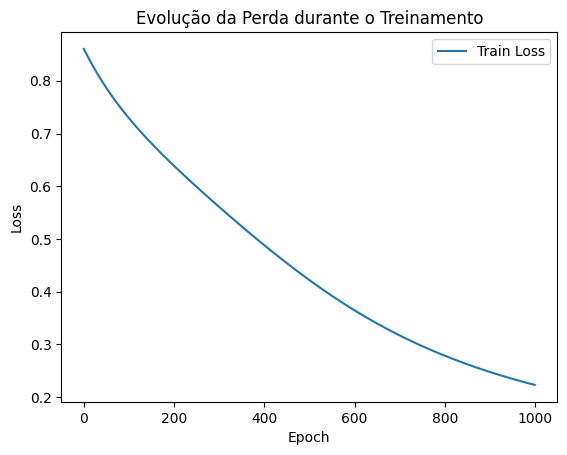

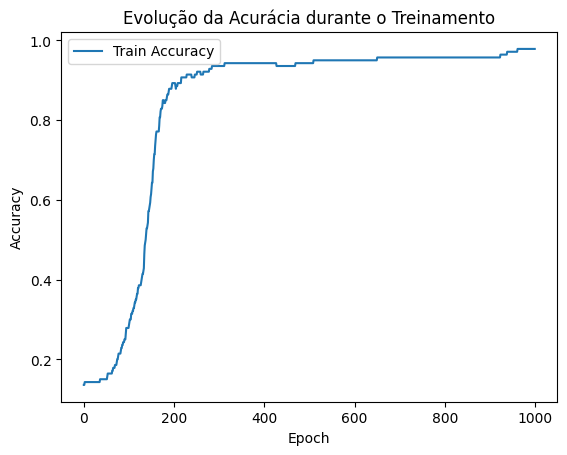

In [79]:
plota_treinamento()

In [81]:
loss, acc = evaluate_model(model_trained, x_test_tensor, y_test_tensor, criterion)
print(f"Teste - Loss: {loss:.4f}, Acurácia: {acc:.4f}")


Teste - Loss: 0.2390, Acurácia: 0.9500


### Salvar e carregar o modelo
Caso queira salvar o modelo para carregar posteriormente, utilize:

In [ ]:
# Para salvar:
torch.save(model.state_dict(), 'modelo_treinado_ex1.pth')

# Para carregar:
# Recrie a arquitetura igual à do treinamento
model = MLP([2, 3, 1], activation='relu')
model.load_state_dict(torch.load('modelo_treinado.pth'))
model.eval()  # coloca em modo de avaliação (sem dropout, etc)
